Initial Setup and Environment Check

In [1]:
!pip install lime

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
from skimage.feature import graycomatrix, graycoprops
from lime import lime_image
import cv2
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
import lime
from lime import lime_tabular
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_kaggle_dataset(dataset_link, extract_to_folder=False, is_competition=False):
    parts = dataset_link.split('/')
    datasets_index = parts.index('datasets')
    dataset_name = '/'.join(parts[datasets_index + 1:datasets_index + 3])
    from google.colab import files
    import os
    #if you've already uploaded kaggle.json before, don't do it again
    if not(os.path.exists("kaggle.json")):
      print("Browse and select your 'kaggle.json' file to download the dataset.")
      files.upload() #upload kaggle.json
    !pip install --upgrade --force-reinstall --no-deps kaggle
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

    if is_competition:
        !kaggle competitions download -c {dataset_name}
        if extract_to_folder:
            !mkdir {dataset_name}
            !unzip -q {dataset_name}.zip -d {dataset_name}
        else:
            !unzip -q {dataset_name}.zip
        !rm -f {dataset_name}.zip
    else:
        dataset_url=dataset_name
        dataset_name=dataset_url.split("/")[1]
        # Download the dataset
        !kaggle datasets download -d  {dataset_url}
        zip_file_name = dataset_name + '.zip'
        # Extract the dataset to the 'chest_xray' folder
        !mkdir chest_xray
        !unzip -q {zip_file_name} -d chest_xray
        !rm -f {zip_file_name}

    !ls

print("\nGetting the dataset...")
get_kaggle_dataset("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

print("\nDirectory info")
!ls -l


Getting the dataset...
  Using cached kaggle-1.7.4.5-py3-none-any.whl.metadata (16 kB)
Using cached kaggle-1.7.4.5-py3-none-any.whl (181 kB)
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:24<00:00, 104MB/s] 
100% 2.29G/2.29G [00:24<00:00, 101MB/s]
mkdir: cannot create directory ‘chest_xray’: File exists
replace chest_xray/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/chest_xray/__MACOSX/chest_xray/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace chest_xray/chest_xray/__MACOSX/chest_xray/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y
A
 chest_xray
 kaggle.jso

In [4]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.19.0
OpenCV version: 4.12.0


Data Loading and Directory Structure

In [5]:
base_dir = 'chest_xray/chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')


Dataset Statistics:
       NORMAL  PNEUMONIA  Total
Train    1341       3875   5216
Test      234        390    624
Val         8          8     16


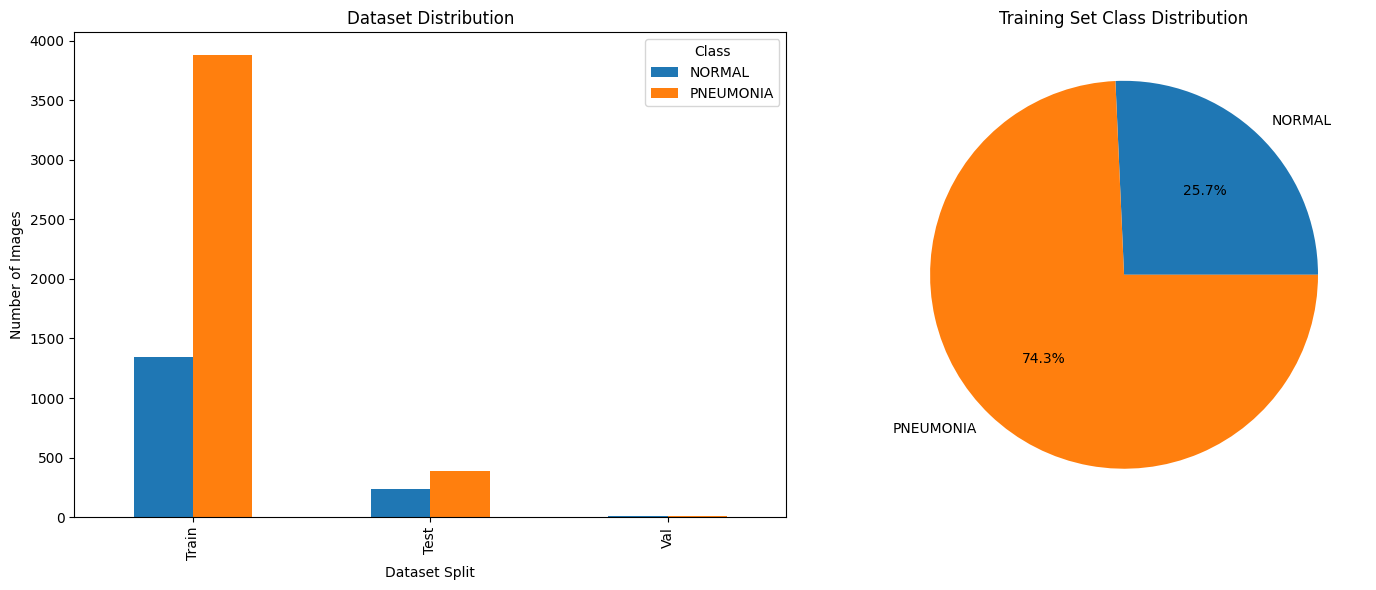


Total Images in Dataset: 5856

Train Split:
Total Images: 5216
NORMAL: 1341 (25.7%)
PNEUMONIA: 3875 (74.3%)

Test Split:
Total Images: 624
NORMAL: 234 (37.5%)
PNEUMONIA: 390 (62.5%)

Val Split:
Total Images: 16
NORMAL: 8 (50.0%)
PNEUMONIA: 8 (50.0%)


In [6]:
def print_dataset_stats():
    stats = {}
    for dir_name, dir_path in [('Train', train_dir), ('Test', test_dir), ('Val', val_dir)]:
        normal = len(os.listdir(os.path.join(dir_path, 'NORMAL')))
        pneumonia = len(os.listdir(os.path.join(dir_path, 'PNEUMONIA')))
        stats[dir_name] = {'NORMAL': normal, 'PNEUMONIA': pneumonia, 'Total': normal + pneumonia}

    df_stats = pd.DataFrame(stats).T
    print("\nDataset Statistics:")
    print(df_stats)

    # Create subplots for better visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    df_stats[['NORMAL', 'PNEUMONIA']].plot(kind='bar', ax=ax1)
    ax1.set_title('Dataset Distribution')
    ax1.set_xlabel('Dataset Split')
    ax1.set_ylabel('Number of Images')
    ax1.legend(title='Class')

    # Pie chart for class distribution in training set
    train_dist = [stats['Train']['NORMAL'], stats['Train']['PNEUMONIA']]
    ax2.pie(train_dist, labels=['NORMAL', 'PNEUMONIA'], autopct='%1.1f%%')
    ax2.set_title('Training Set Class Distribution')

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    total_images = sum(stats[split]['Total'] for split in stats)
    print(f"\nTotal Images in Dataset: {total_images}")
    for split in stats:
        total = stats[split]['Total']
        normal_pct = (stats[split]['NORMAL'] / total) * 100
        pneumonia_pct = (stats[split]['PNEUMONIA'] / total) * 100
        print(f"\n{split} Split:")
        print(f"Total Images: {total}")
        print(f"NORMAL: {stats[split]['NORMAL']} ({normal_pct:.1f}%)")
        print(f"PNEUMONIA: {stats[split]['PNEUMONIA']} ({pneumonia_pct:.1f}%)")

print_dataset_stats()

Noise Analysis and Preprocessing Functions

In [7]:
def analyze_image_noise(image_path):
    img = cv2.imread(image_path, 0)
    if img is None:
        return None
    # Calculate multiple noise metrics
    std_dev = np.std(img)
    entropy = -np.sum(np.histogram(img, bins=256, density=True)[0] *
                     np.log2(np.histogram(img, bins=256, density=True)[0] + 1e-10))
    return {
        'std_dev': std_dev,
        'entropy': entropy,
        'mean': np.mean(img),
        'variance': np.var(img)
    }

In [8]:
def preprocess_image(image, apply_noise_reduction=True):
    if apply_noise_reduction:
        # Apply multiple noise reduction techniques
        # 1. Gaussian blur
        blurred = cv2.GaussianBlur(image, (5, 5), 0)
        # 2. Median filtering
        median = cv2.medianBlur(blurred, 5)
        # 3. Bilateral filtering for edge preservation
        bilateral = cv2.bilateralFilter(median, 9, 75, 75)
        return bilateral
    return image


Noise Metrics for NORMAL:
Original Image:
std_dev: 67.93
entropy: 7.14
mean: 102.72
variance: 4614.31

Processed Image:
std_dev: 67.55
entropy: 7.25
mean: 102.70
variance: 4562.55

Noise Metrics for PNEUMONIA:
Original Image:
std_dev: 53.11
entropy: 7.35
mean: 164.82
variance: 2820.38

Processed Image:
std_dev: 52.59
entropy: 7.35
mean: 164.82
variance: 2765.23


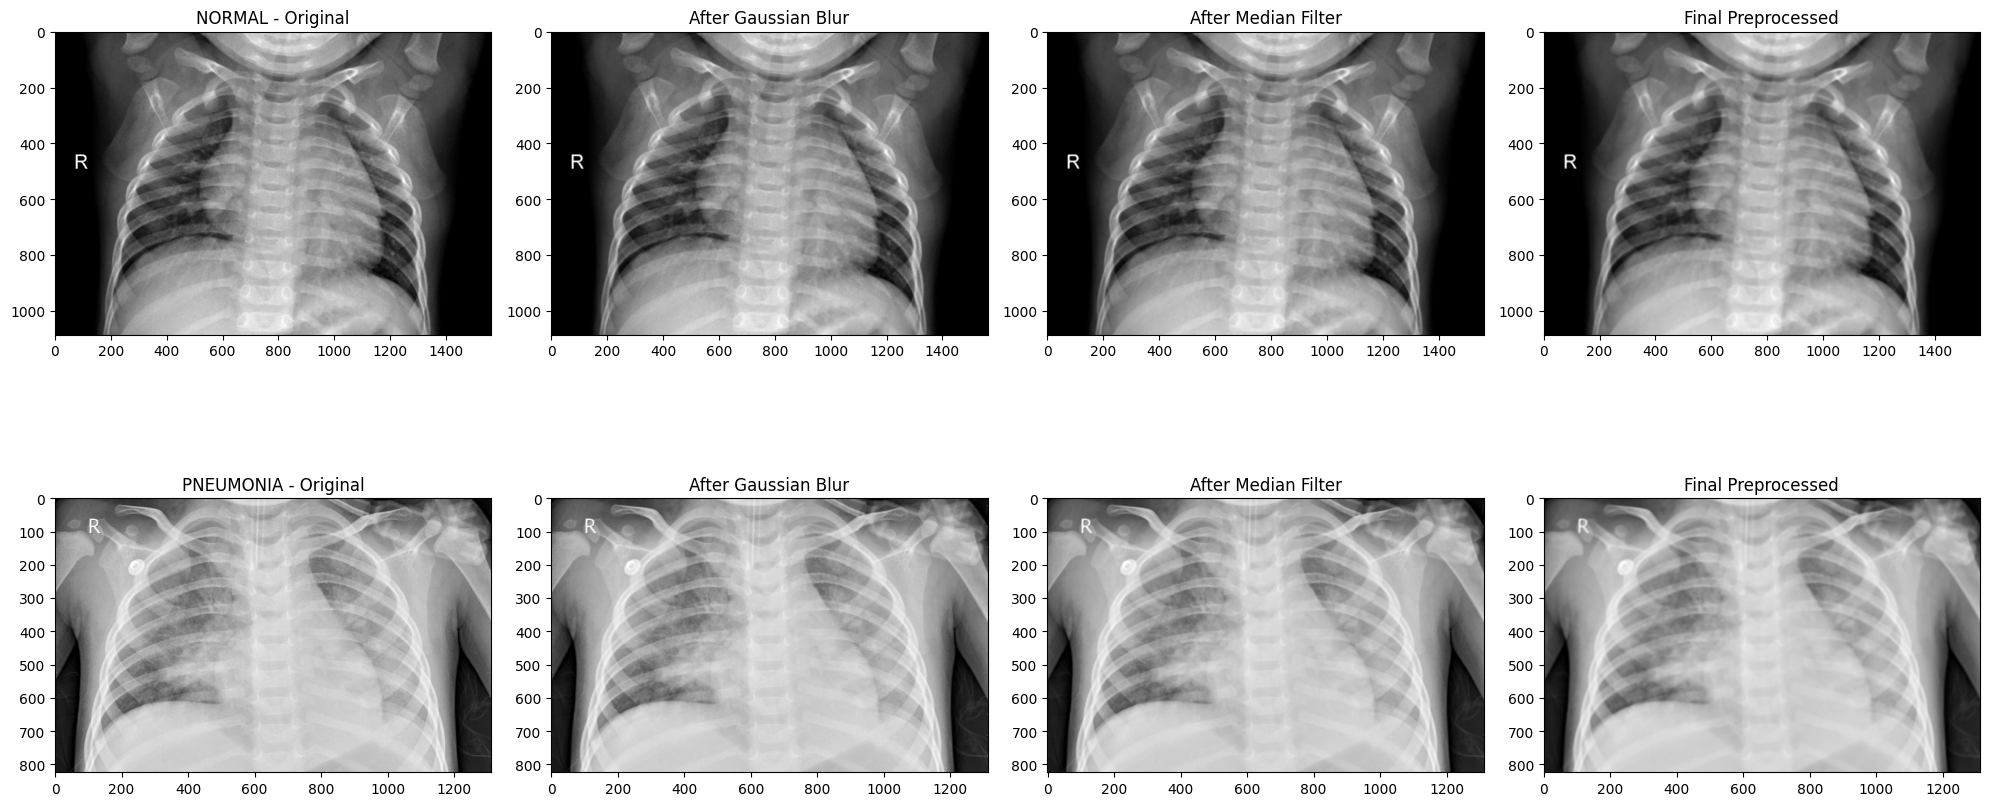

In [9]:
def visualize_preprocessing_effects():
    # Get sample images
    normal_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
    pneumonia_path = os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0])

    images = {'NORMAL': normal_path, 'PNEUMONIA': pneumonia_path}

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    for idx, (label, img_path) in enumerate(images.items()):
        img = cv2.imread(img_path, 0)

        # Original
        axes[idx, 0].imshow(img, cmap='gray')
        axes[idx, 0].set_title(f'{label} - Original')

        # Gaussian Blur
        gaussian = cv2.GaussianBlur(img, (5, 5), 0)
        axes[idx, 1].imshow(gaussian, cmap='gray')
        axes[idx, 1].set_title('After Gaussian Blur')

        # Median Filter
        median = cv2.medianBlur(gaussian, 5)
        axes[idx, 2].imshow(median, cmap='gray')
        axes[idx, 2].set_title('After Median Filter')

        # Final Preprocessing
        final = preprocess_image(img)
        axes[idx, 3].imshow(final, cmap='gray')
        axes[idx, 3].set_title('Final Preprocessed')

        # Calculate and print noise metrics
        original_metrics = analyze_image_noise(img_path)
        processed_img_path = '/tmp/processed.png'
        cv2.imwrite(processed_img_path, final)
        processed_metrics = analyze_image_noise(processed_img_path)

        print(f"\nNoise Metrics for {label}:")
        print("Original Image:")
        for metric, value in original_metrics.items():
            print(f"{metric}: {value:.2f}")
        print("\nProcessed Image:")
        for metric, value in processed_metrics.items():
            print(f"{metric}: {value:.2f}")

    plt.tight_layout()
    plt.show()

visualize_preprocessing_effects()

Feature Engineering Functions

In [10]:
def extract_texture_features(image):
    # Convert to 8-bit image if needed
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Calculate GLCM features
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(image, distances=distances, angles=angles,
                       levels=256, symmetric=True, normed=True)

    # Extract Haralick features
    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean(),
        'ASM': graycoprops(glcm, 'ASM').mean()
    }

    return features

In [11]:
def extract_statistical_features(image):
    # First-order statistics
    features = {
        'mean': np.mean(image),
        'std': np.std(image),
        'variance': np.var(image),
        'skewness': np.mean(((image - np.mean(image))/np.std(image))**3),
        'kurtosis': np.mean(((image - np.mean(image))/np.std(image))**4) - 3,
        'entropy': -np.sum(np.histogram(image, bins=256, density=True)[0] *
                          np.log2(np.histogram(image, bins=256, density=True)[0] + 1e-10))
    }

    return features

def extract_all_features(image_path, apply_noise_reduction=True):
    # Load and preprocess image
    img = cv2.imread(image_path, 0)
    img = cv2.resize(img, (224, 224))

    if apply_noise_reduction:
        img = preprocess_image(img)

    # Extract features
    texture_feats = extract_texture_features(img)
    stat_feats = extract_statistical_features(img)

    # Combine all features
    features = {**texture_feats, **stat_feats}
    return features

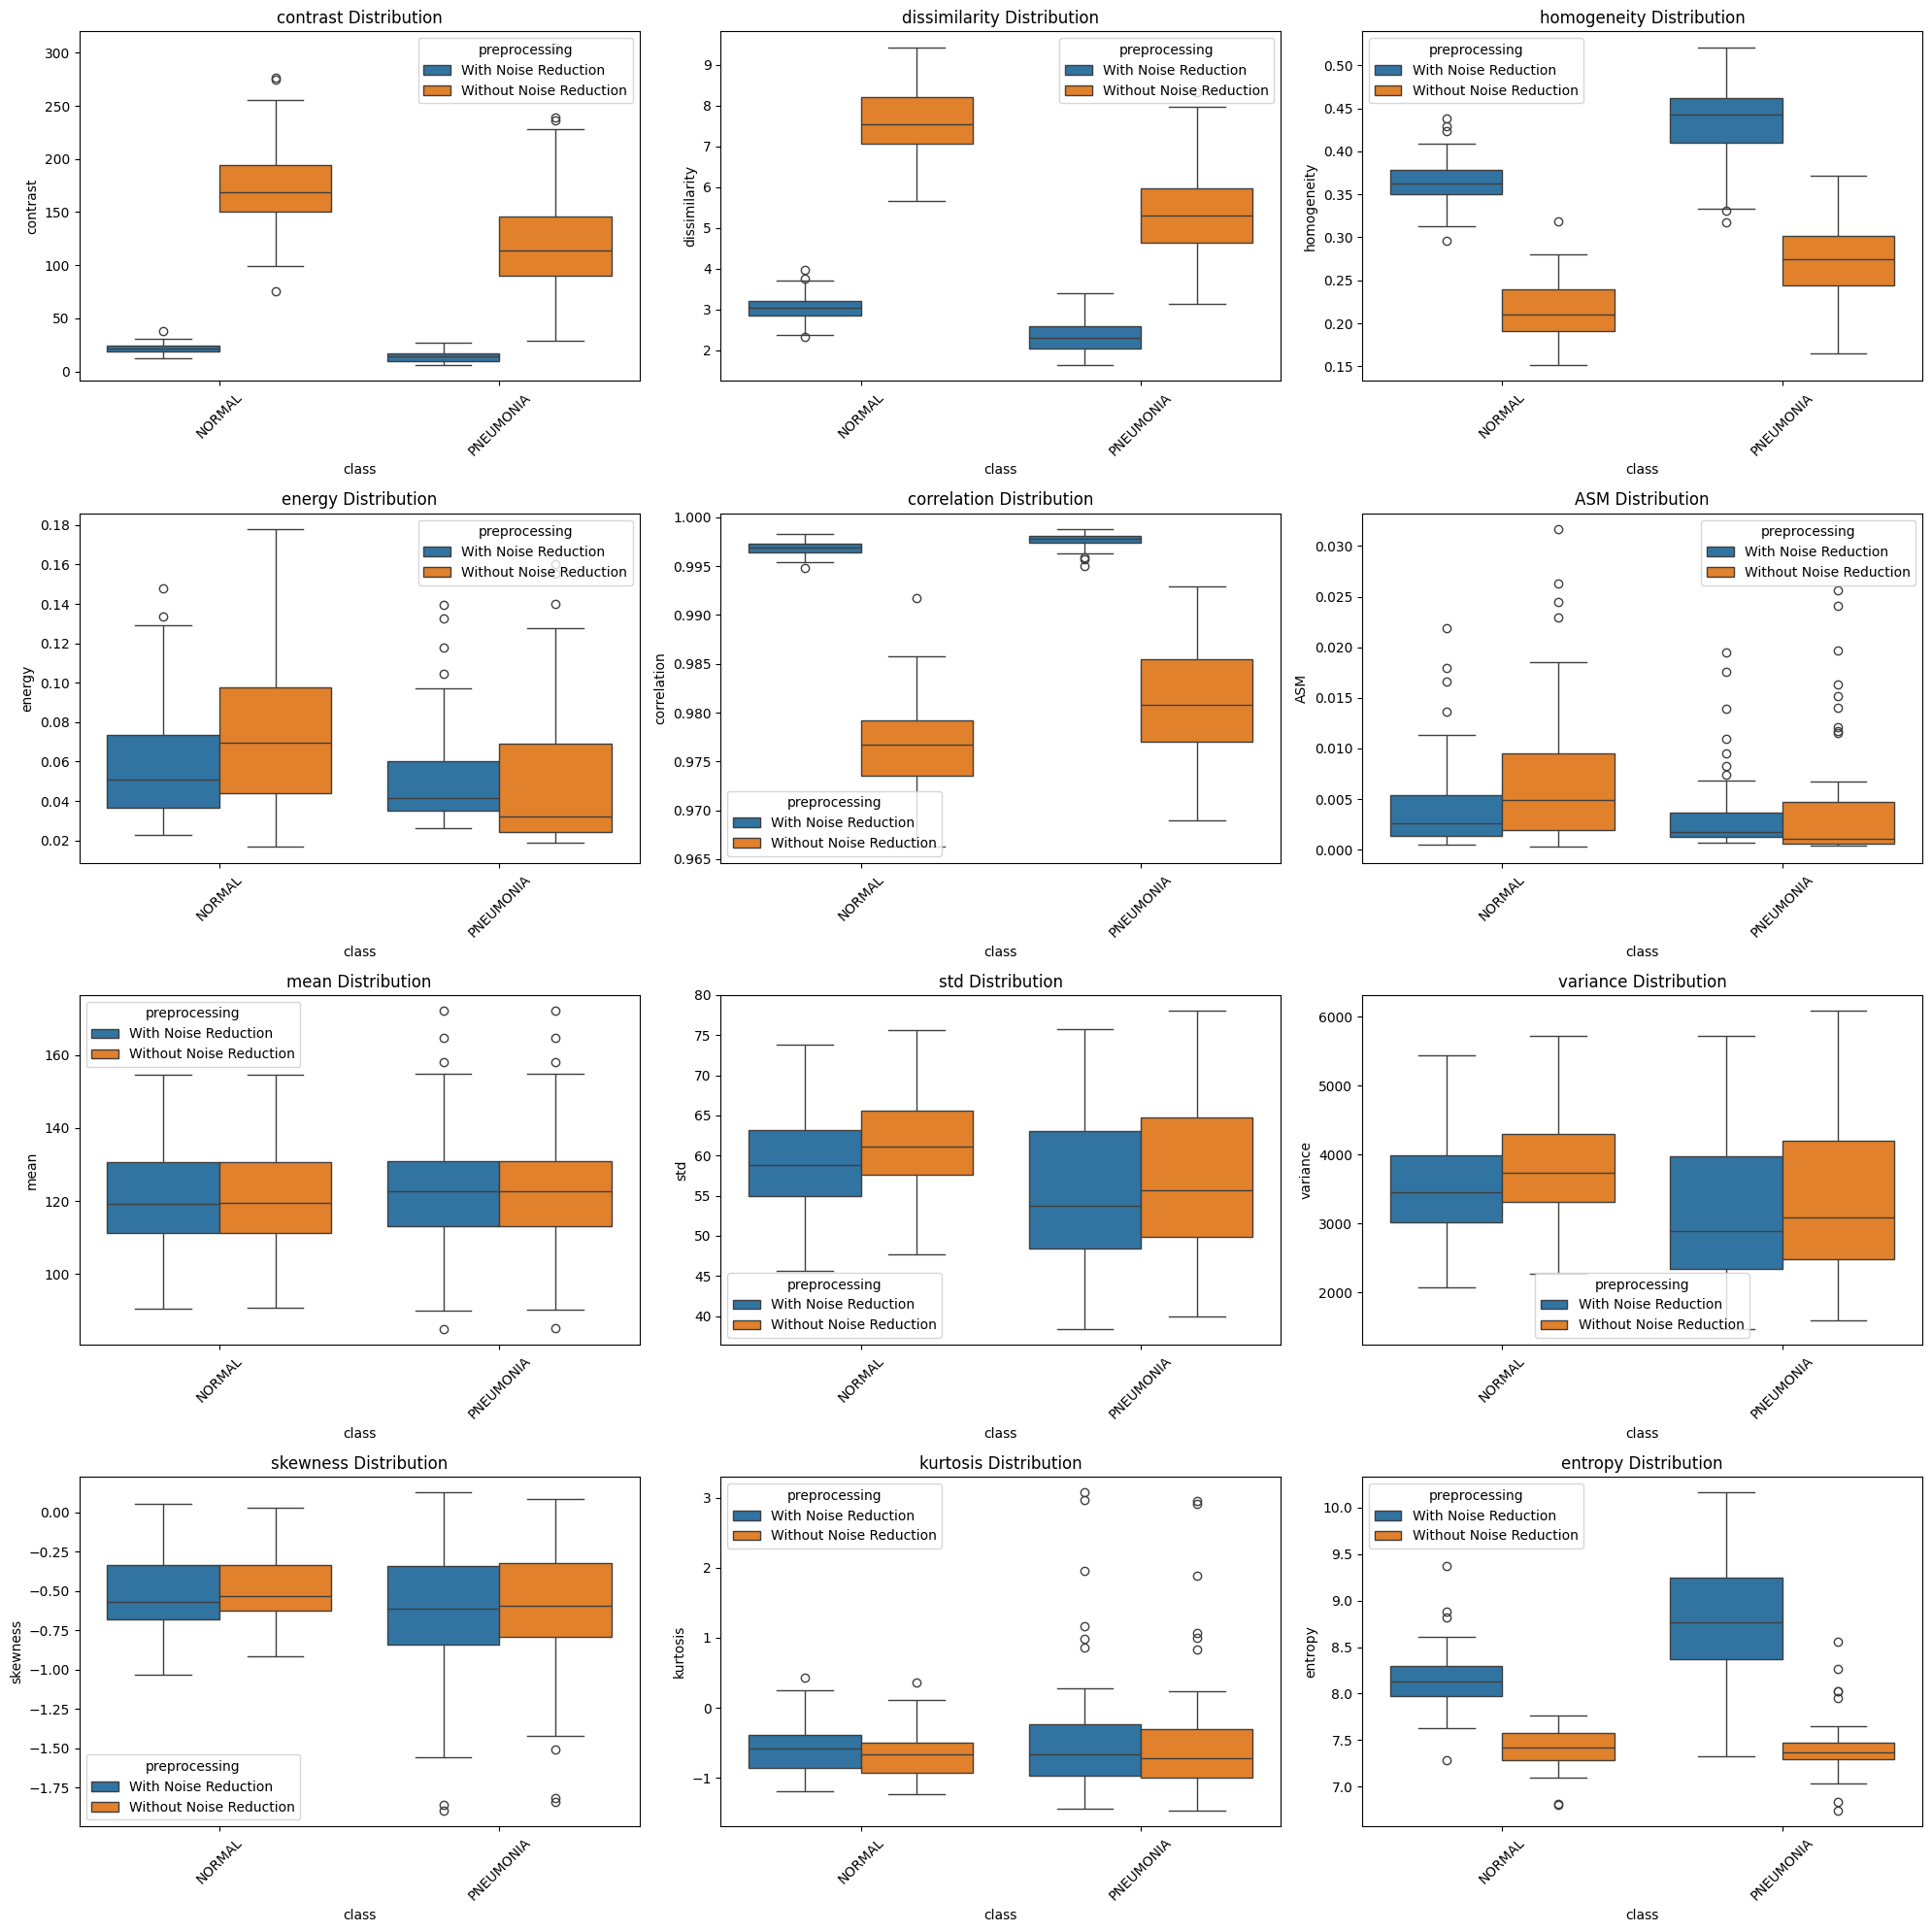


Feature Analysis:

contrast:

With Noise Reduction:
NORMAL:
  Mean: 21.7393
  Std:  4.8408
PNEUMONIA:
  Mean: 14.0784
  Std:  4.8827

Without Noise Reduction:
NORMAL:
  Mean: 174.1127
  Std:  41.1625
PNEUMONIA:
  Mean: 123.7107
  Std:  55.0928

dissimilarity:

With Noise Reduction:
NORMAL:
  Mean: 3.0678
  Std:  0.3253
PNEUMONIA:
  Mean: 2.3406
  Std:  0.4110

Without Noise Reduction:
NORMAL:
  Mean: 7.5640
  Std:  0.9495
PNEUMONIA:
  Mean: 5.4422
  Std:  1.1127

homogeneity:

With Noise Reduction:
NORMAL:
  Mean: 0.3634
  Std:  0.0295
PNEUMONIA:
  Mean: 0.4370
  Std:  0.0457

Without Noise Reduction:
NORMAL:
  Mean: 0.2144
  Std:  0.0375
PNEUMONIA:
  Mean: 0.2738
  Std:  0.0491

energy:

With Noise Reduction:
NORMAL:
  Mean: 0.0590
  Std:  0.0303
PNEUMONIA:
  Mean: 0.0536
  Std:  0.0271

Without Noise Reduction:
NORMAL:
  Mean: 0.0759
  Std:  0.0403
PNEUMONIA:
  Mean: 0.0524
  Std:  0.0398

correlation:

With Noise Reduction:
NORMAL:
  Mean: 0.9968
  Std:  0.0007
PNEUMONIA:
  Mean: 0

In [12]:
# Visualize feature distributions
def analyze_features(n_samples=50):
    features_data = []

    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(train_dir, class_name)
        image_files = os.listdir(class_path)[:n_samples]

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)

            # Extract features with and without noise reduction
            features_with_nr = extract_all_features(img_path, True)
            features_without_nr = extract_all_features(img_path, False)

            # Add to data
            features_data.append({
                'class': class_name,
                'preprocessing': 'With Noise Reduction',
                **features_with_nr
            })
            features_data.append({
                'class': class_name,
                'preprocessing': 'Without Noise Reduction',
                **features_without_nr
            })

    # Convert to DataFrame
    df_features = pd.DataFrame(features_data)

    # Visualize distributions
    feature_names = [col for col in df_features.columns
                    if col not in ['class', 'preprocessing']]

    n_features = len(feature_names)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    plt.figure(figsize=(20, 5*n_rows))

    for idx, feature in enumerate(feature_names, 1):
        plt.subplot(n_rows, n_cols, idx)

        sns.boxplot(data=df_features, x='class', y=feature,
                   hue='preprocessing')
        plt.title(f'{feature} Distribution')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Print statistical analysis
    print("\nFeature Analysis:")
    for feature in feature_names:
        print(f"\n{feature}:")
        for prep in ['With Noise Reduction', 'Without Noise Reduction']:
            print(f"\n{prep}:")
            for class_name in ['NORMAL', 'PNEUMONIA']:
                data = df_features[(df_features['class'] == class_name) &
                                 (df_features['preprocessing'] == prep)][feature]
                print(f"{class_name}:")
                print(f"  Mean: {data.mean():.4f}")
                print(f"  Std:  {data.std():.4f}")

analyze_features()

In [13]:
def prepare_dataset(n_samples=100):
    X = []
    y = []
    feature_names = []

    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(train_dir, class_name)
        image_files = os.listdir(class_path)[:n_samples]

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            features = extract_all_features(img_path, True)

            if not feature_names:
                feature_names = list(features.keys())

            X.append(list(features.values()))
            y.append(1 if class_name == 'PNEUMONIA' else 0)

    X = np.array(X)
    y = np.array(y)

    return X, y, feature_names

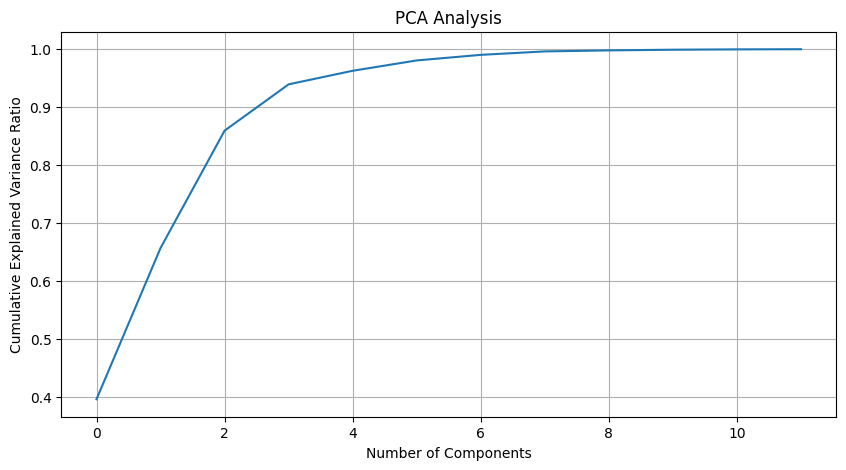

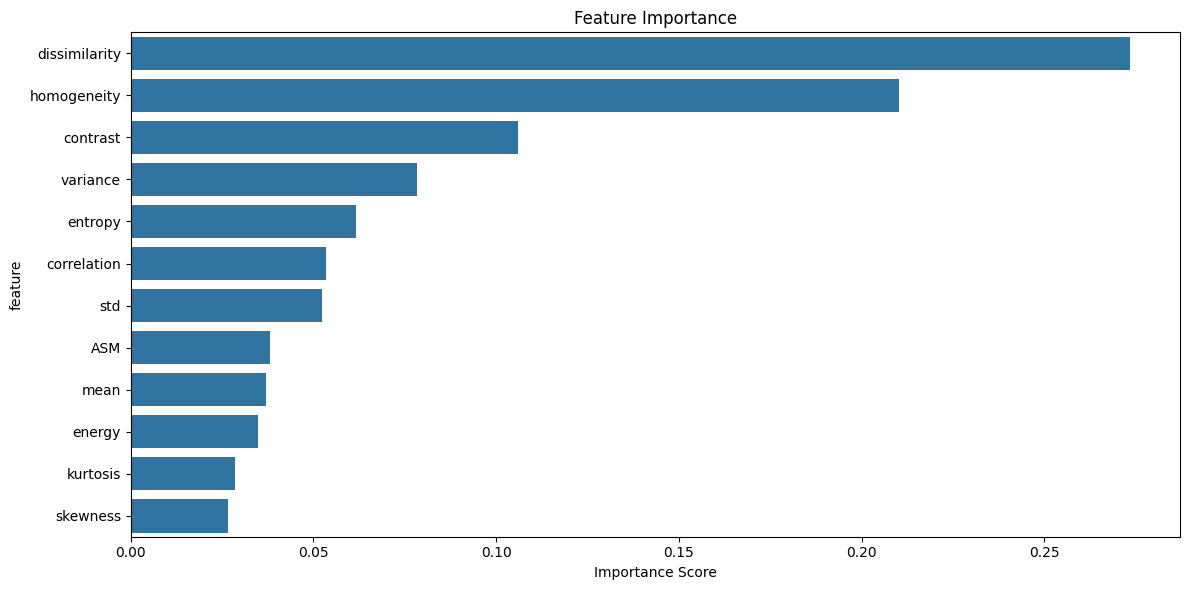


Top 5 Most Important Features:
          feature  importance
1   dissimilarity    0.273490
2     homogeneity    0.210223
0        contrast    0.105878
8        variance    0.078306
11        entropy    0.061610


In [14]:
def analyze_feature_importance(X, y, feature_names):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Plot explained variance ratio
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Analysis')
    plt.grid(True)
    plt.show()

    # Feature importance using Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)

    # Plot feature importance
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance, x='importance', y='feature')
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    print("\nTop 5 Most Important Features:")
    print(importance.head())

    return pca, importance

# Prepare dataset and analyze features
X, y, feature_names = prepare_dataset()
pca, feature_importance = analyze_feature_importance(X, y, feature_names)

Model Training and Cross-Validation


Evaluating Random Forest:
Mean CV Accuracy: 0.860 (±0.044)

Evaluating SVM:
Mean CV Accuracy: 0.890 (±0.034)

Evaluating Neural Network:
Mean CV Accuracy: 0.875 (±0.052)


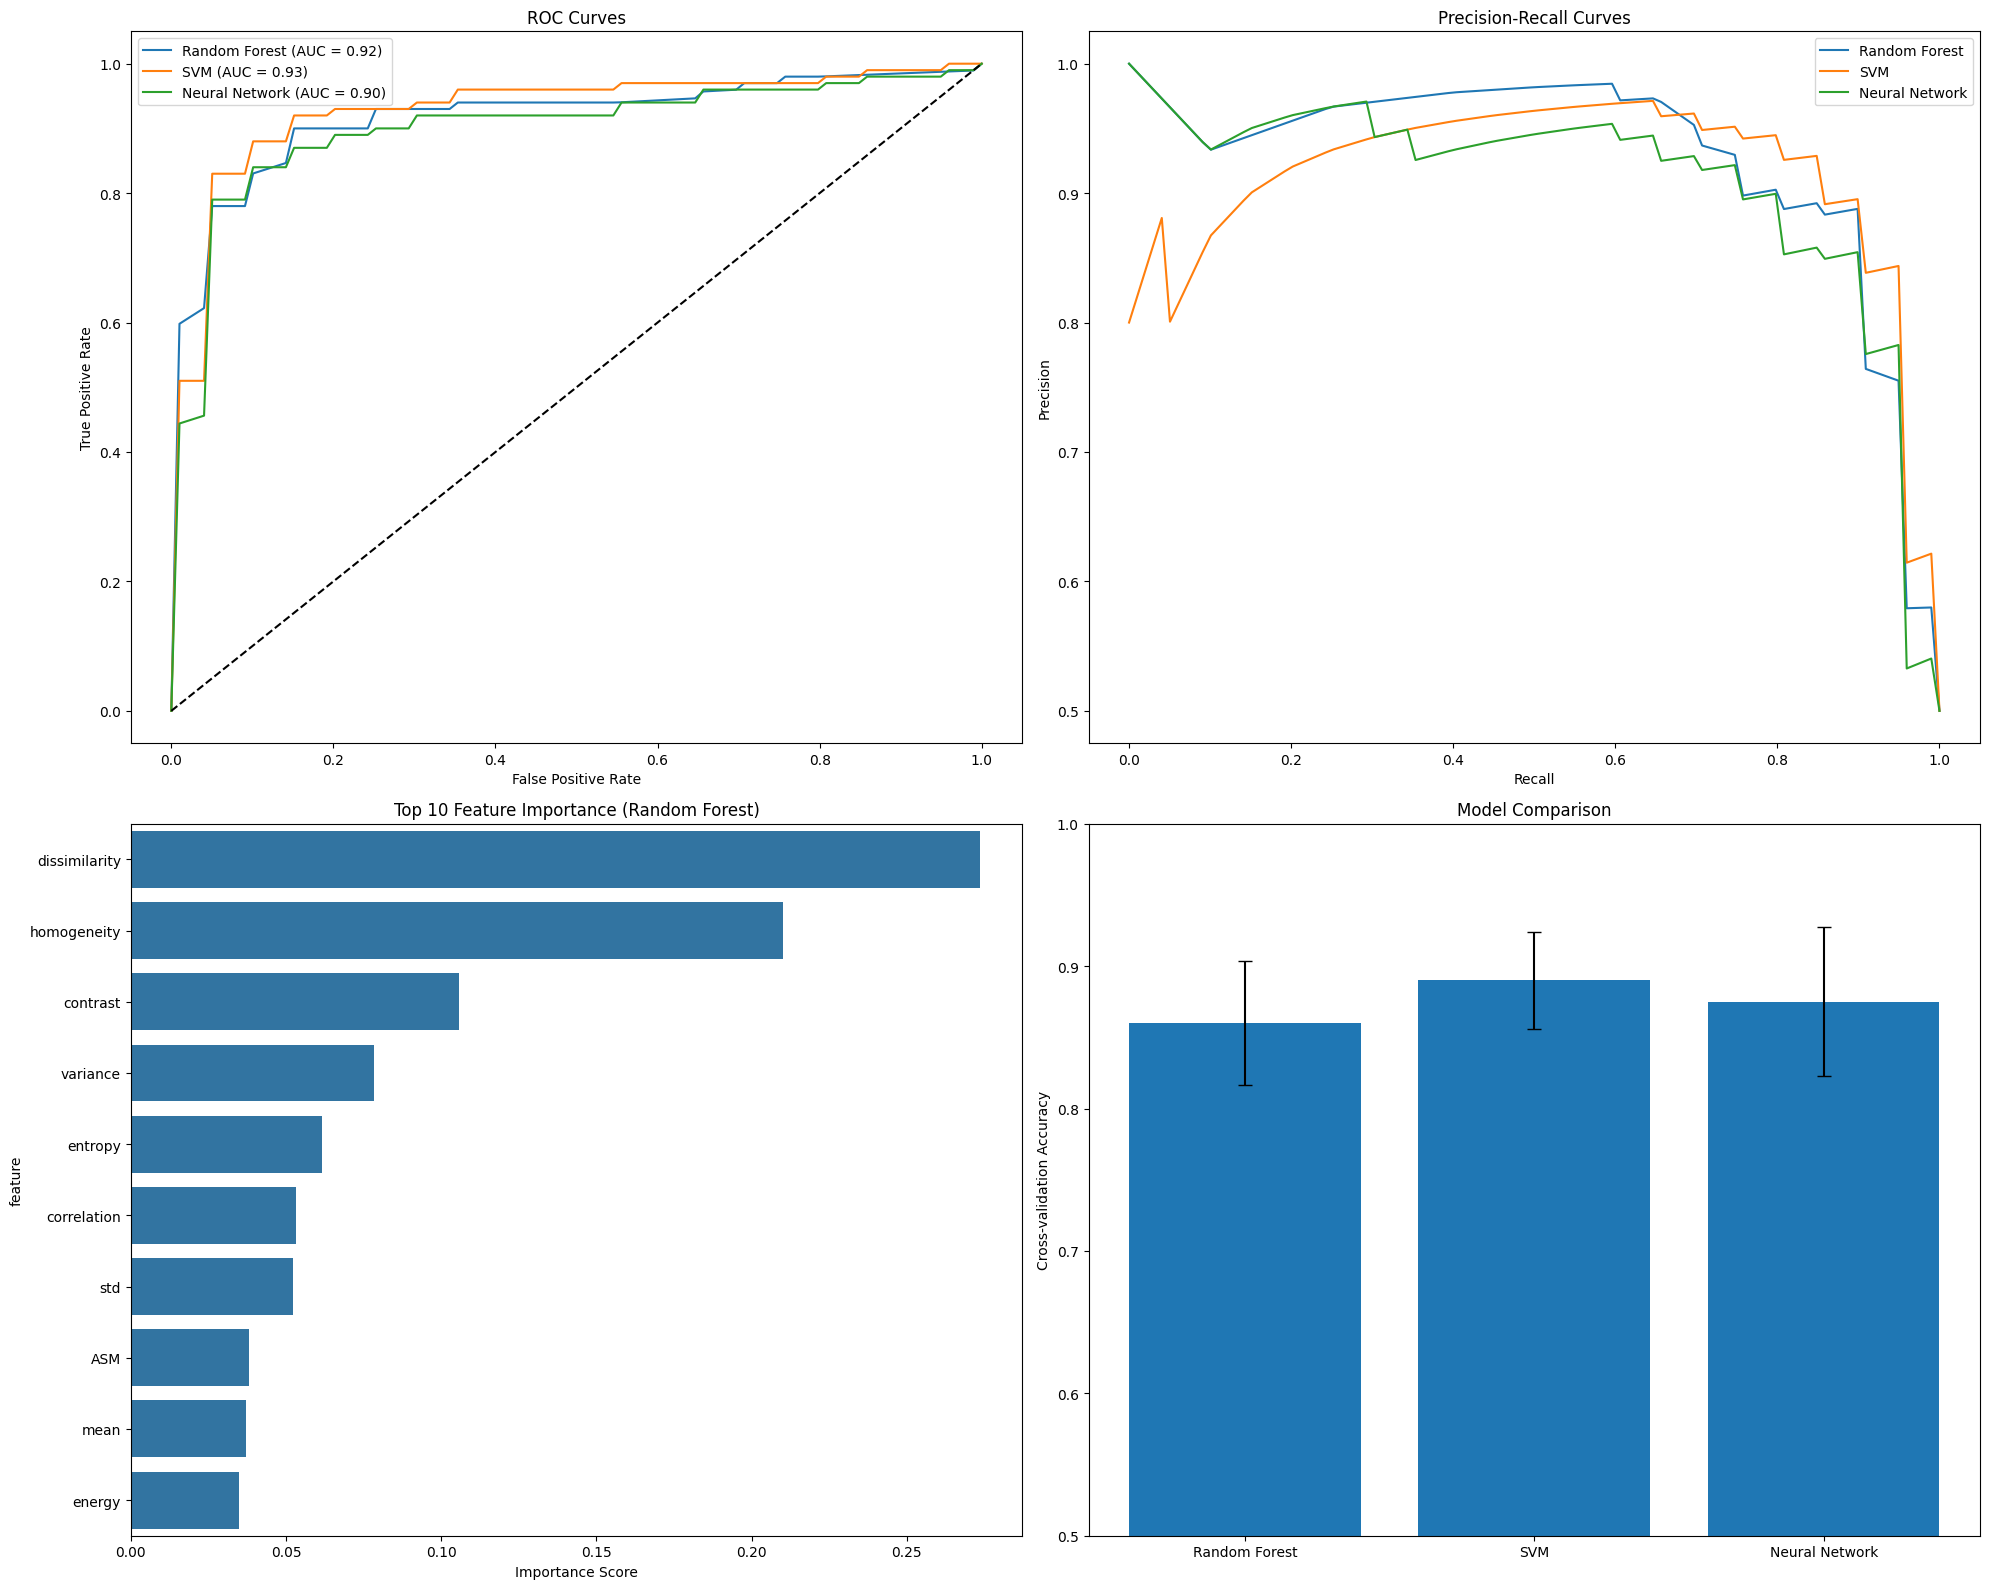

In [15]:
# Initialize models globally
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Initialize scaler globally
scaler = StandardScaler()

def train_evaluate_models(X, y, feature_names):
    # Standardize features
    global scaler
    X_scaled = scaler.fit_transform(X)

    # Results storage
    results = {}

    # Plotting setup
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}:")

        # Cross-validation scores
        cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
        results[model_name] = {
            'cv_scores': cv_scores,
            'mean_cv': cv_scores.mean(),
            'std_cv': cv_scores.std()
        }

        # ROC and PR curves using cross-validation
        tprs = []
        aucs = []
        precisions = []
        recalls = []
        mean_fpr = np.linspace(0, 1, 100)

        for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
            model.fit(X_scaled[train_idx], y[train_idx])
            probas = model.predict_proba(X_scaled[val_idx])

            # ROC
            fpr, tpr, _ = roc_curve(y[val_idx], probas[:, 1])
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(auc(fpr, tpr))

            # Precision-Recall
            precision, recall, _ = precision_recall_curve(y[val_idx], probas[:, 1])
            precisions.append(np.interp(mean_fpr, recall[::-1], precision[::-1]))

        # Plot ROC curves
        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = np.mean(aucs)
        ax1.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f})')

        # Plot PR curves
        mean_precision = np.mean(precisions, axis=0)
        ax2.plot(mean_fpr, mean_precision, label=f'{model_name}')

        print(f"Mean CV Accuracy: {results[model_name]['mean_cv']:.3f} "
              f"(±{results[model_name]['std_cv']:.3f})")

        # Feature importance for Random Forest
        if model_name == 'Random Forest':
            model.fit(X_scaled, y)
            importance = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            sns.barplot(data=importance.head(10), x='importance', y='feature', ax=ax3)
            ax3.set_title('Top 10 Feature Importance (Random Forest)')
            ax3.set_xlabel('Importance Score')

    # Compare model performances
    cv_means = [results[model]['mean_cv'] for model in models]
    cv_stds = [results[model]['std_cv'] for model in models]

    ax4.bar(models.keys(), cv_means, yerr=cv_stds, capsize=5)
    ax4.set_title('Model Comparison')
    ax4.set_ylabel('Cross-validation Accuracy')
    ax4.set_ylim(0.5, 1.0)

    # Finalize plots
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend()

    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return results, X_scaled

# Assuming X, y, and feature_names are already defined
results, X_scaled = train_evaluate_models(X, y, feature_names)

In [16]:
def explain_predictions(model, X_scaled, feature_names, n_samples=3):
    # Initialize LIME explainer
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_scaled,
        feature_names=feature_names,
        class_names=['Normal', 'Pneumonia'],
        mode='classification',
        random_state=42
    )

    plt.figure(figsize=(15, 5*n_samples))

    for i in range(n_samples):
        # Get random sample
        idx = np.random.randint(len(X_scaled))

        # Generate explanation
        exp = explainer.explain_instance(
            data_row=X_scaled[idx],
            predict_fn=model.predict_proba,
            num_features=10
        )

        # Plot explanation
        plt.subplot(n_samples, 1, i+1)
        exp.as_pyplot_figure()
        plt.title(f'Sample {i+1} Explanation')

    plt.tight_layout()
    plt.show()

In [17]:
def prepare_test_data():
    test_X = []
    test_y = []
    test_paths = []

    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(test_dir, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            features = extract_all_features(img_path, True)

            test_X.append(list(features.values()))
            test_y.append(1 if class_name == 'PNEUMONIA' else 0)
            test_paths.append(img_path)

    return np.array(test_X), np.array(test_y), test_paths

In [18]:
def evaluate_final_model(model, test_X, test_y, test_paths):
    # Scale test data using the global scaler
    test_X_scaled = scaler.transform(test_X)

    # Make predictions
    predictions = model.predict(test_X_scaled)
    probas = model.predict_proba(test_X_scaled)

    # Calculate metrics
    print("\nTest Set Performance:")
    print(classification_report(test_y, predictions))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(test_y, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Analyze misclassifications
    misclassified_idx = np.where(predictions != test_y)[0]

    if len(misclassified_idx) > 0:
        print("\nAnalyzing misclassified cases:")
        for idx in misclassified_idx[:5]:  # Show first 5 misclassifications
            print(f"\nImage: {test_paths[idx]}")
            print(f"Actual: {'PNEUMONIA' if test_y[idx] == 1 else 'NORMAL'}")
            print(f"Predicted: {'PNEUMONIA' if predictions[idx] == 1 else 'NORMAL'}")
            print(f"Probability: {probas[idx][1]:.3f}")


Best performing model: SVM with accuracy 0.890


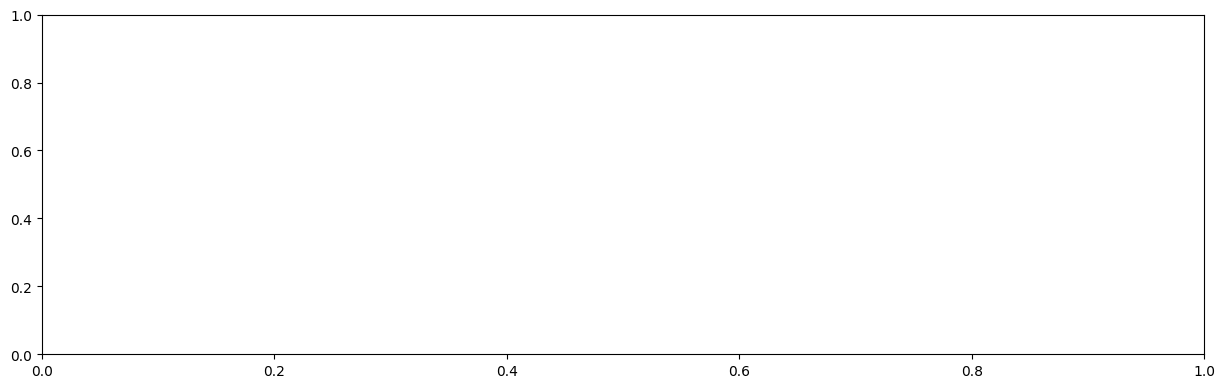

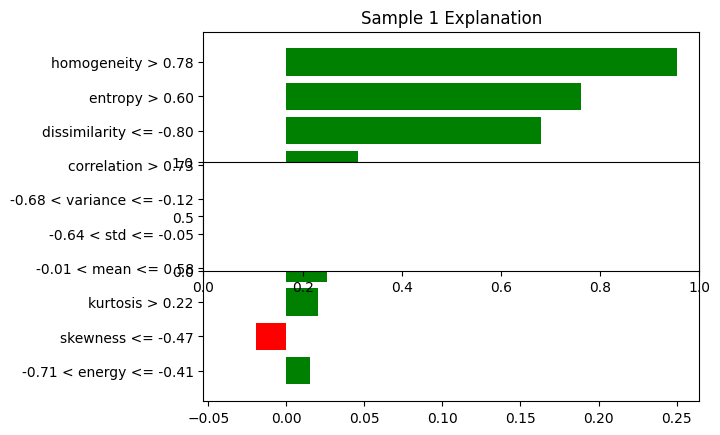

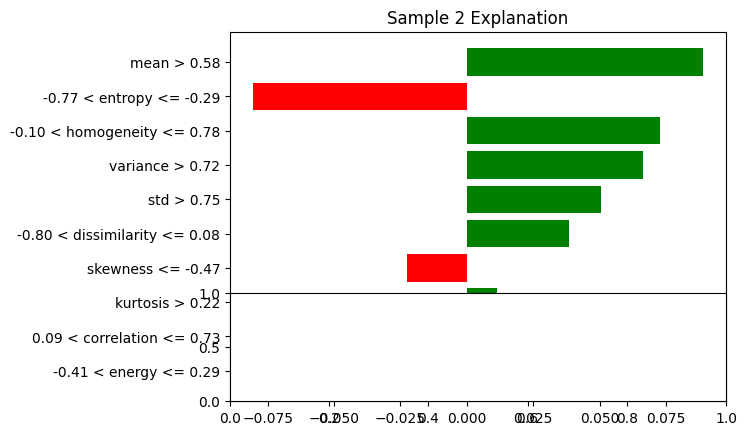

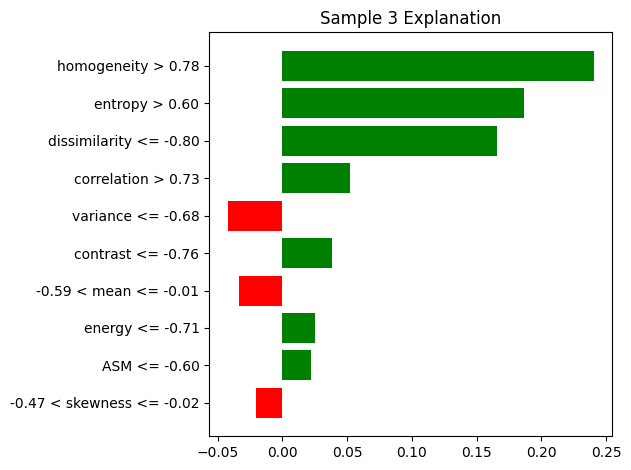

In [19]:
# Get best model from results
best_model = None
best_score = 0
for model_name, result in results.items():
    if result['mean_cv'] > best_score:
        best_score = result['mean_cv']
        best_model = model_name

print(f"\nBest performing model: {best_model} with accuracy {best_score:.3f}")

# Retrain best model and generate explanations
model = models[best_model]
model.fit(X_scaled, y)
explain_predictions(model, X_scaled, feature_names)


Test Set Performance:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       234
           1       0.84      0.82      0.83       390

    accuracy                           0.79       624
   macro avg       0.78      0.78      0.78       624
weighted avg       0.79      0.79      0.79       624



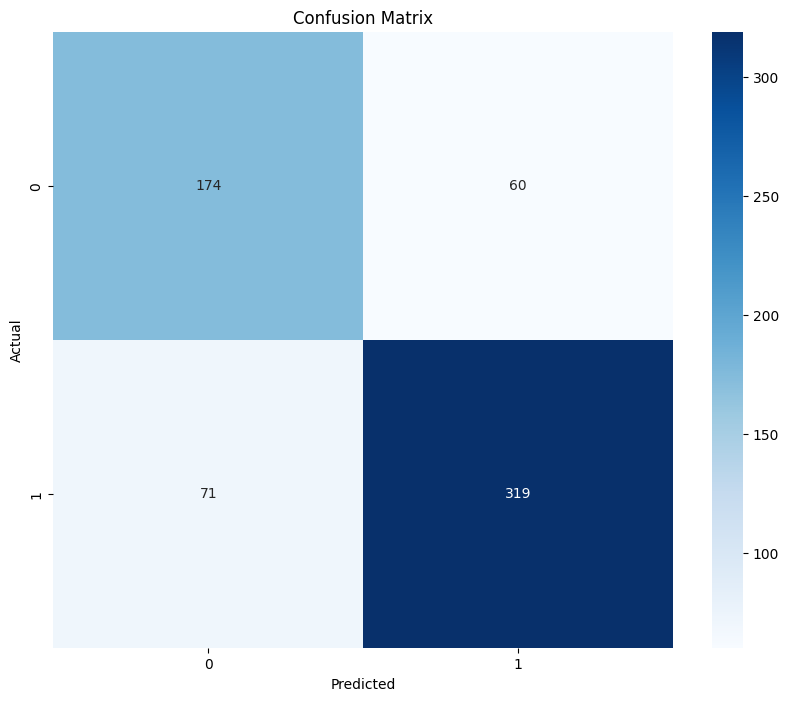


Analyzing misclassified cases:

Image: chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0361-0001.jpeg
Actual: NORMAL
Predicted: PNEUMONIA
Probability: 0.565

Image: chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg
Actual: NORMAL
Predicted: PNEUMONIA
Probability: 0.700

Image: chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0092-0001.jpeg
Actual: NORMAL
Predicted: PNEUMONIA
Probability: 0.822

Image: chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0210-0001.jpeg
Actual: NORMAL
Predicted: PNEUMONIA
Probability: 0.917

Image: chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0232-0001.jpeg
Actual: NORMAL
Predicted: PNEUMONIA
Probability: 0.942


In [20]:
# Prepare and evaluate test data
test_X, test_y, test_paths = prepare_test_data()
evaluate_final_model(model, test_X, test_y, test_paths)